L1 reg

Dropped columns: 295 ['ACCESS_BLOBS_ACROSS_USERS', 'BIND_CARRIER_MESSAGING_CLIENT_SERVICE', 'BIND_COMPANION_DEVICE_SERVICE', 'BIND_CONTROLS', 'BIND_QUICK_ACCESS_WALLET_SERVICE', 'BIND_TV_INTERACTIVE_APP', 'BIND_VISUAL_VOICEMAIL_SERVICE', 'BODY_SENSORS_BACKGROUND', 'DELIVER_COMPANION_MESSAGES', 'HIDE_OVERLAY_WINDOWS', 'LAUNCH_MULTI_PANE_SETTINGS_DEEP_LINK', 'LOADER_USAGE_STATS', 'MANAGE_MEDIA', 'MANAGE_ONGOING_CALLS', 'MANAGE_WIFI_INTERFACES', 'MANAGE_WIFI_NETWORK_SELECTION', 'NEARBY_WIFI_DEVICES', 'NFC_PREFERRED_PAYMENT_INFO', 'READ_ASSISTANT_APP_SEARCH_DATA', 'READ_BASIC_PHONE_STATE', 'READ_HOME_APP_SEARCH_DATA', 'READ_NEARBY_STREAMING_POLICY', 'READ_VOICEMAIL', 'REQUEST_COMPANION_PROFILE_APP_STREAMING', 'REQUEST_COMPANION_PROFILE_AUTOMOTIVE_PROJECTION', 'REQUEST_COMPANION_PROFILE_COMPUTER', 'REQUEST_COMPANION_PROFILE_WATCH', 'REQUEST_COMPANION_SELF_MANAGED', 'REQUEST_COMPANION_START_FOREGROUND_SERVICES_FROM_BACKGROUND', 'REQUEST_OBSERVE_COMPANION_DEVICE_PRESENCE', 'SMS_FINANCIAL_TRAN

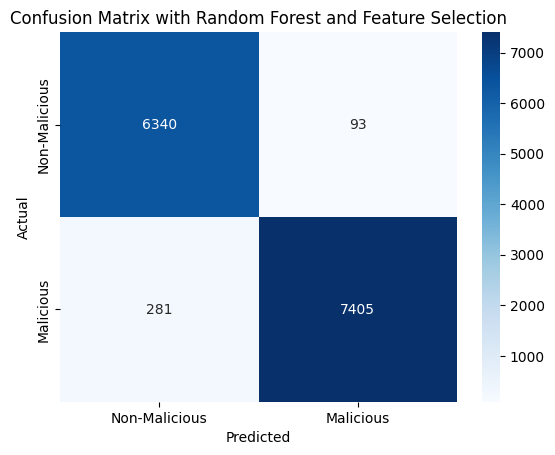

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the data loading and preprocessing steps are the same
# Assuming the data loading and preprocessing steps are the same
file_path = '/Users/sunishkasharma/Downloads/Project - 1 _ Machine Learning/combinedcsv.csv'
df = pd.read_csv(file_path)
# Drop columns containing only a single value
columns_drop = list()
for column in df.columns:
    unique_values = df[column].unique()
    if len(unique_values) == 1:
        columns_drop.append(column)

df.drop(columns_drop, axis=1, inplace=True)
print(f"Dropped columns: {len(columns_drop)}", columns_drop)

# Separate the target variable ('malicious' column)
X = df.drop(columns=['malicious', 'md5_hash'])
y = df['malicious']
# Split the data into training (60%), validation (20%), and testing (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the features (important for logistic regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Feature selection using Logistic Regression with L1 regularization
param_grid_logistic = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization strength
    'penalty': ['l1'],
    'solver': ['liblinear']  # Solver that supports L1 penalty
}

grid_search_logistic = GridSearchCV(LogisticRegression(), param_grid_logistic, cv=5, scoring='accuracy', verbose=2, n_jobs=2)
grid_search_logistic.fit(X_train, y_train)

# Use the best estimator to identify important features
best_logistic = grid_search_logistic.best_estimator_
important_features = np.where(best_logistic.coef_[0] != 0)[0]

# Select only the important features for the Random Forest model
X_train_selected = X_train[:, important_features]
X_valid_selected = X_valid[:, important_features]  # Corrected line
X_test_selected = X_test[:, important_features]

# Train a Random Forest Classifier on the selected features with specified hyperparameters
rf_model_selected = RandomForestClassifier(
    n_estimators=300, 
    max_depth=30, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    random_state=42
)
rf_model_selected.fit(X_train_selected, y_train)

# Make predictions and evaluate the model on the validation set
y_pred_rf_selected = rf_model_selected.predict(X_valid_selected)  # Corrected line

# Evaluate the Random Forest model with feature selection
accuracy_rf_selected = accuracy_score(y_valid, y_pred_rf_selected)  # Corrected line
print(f'Accuracy with Random Forest and Feature Selection: {accuracy_rf_selected:.2f}')

# Display classification report and confusion matrix for Random Forest with feature selection
print('\nClassification Report with Random Forest and Feature Selection:')
print(classification_report(y_valid, y_pred_rf_selected))  # Corrected line

print('\nConfusion Matrix with Random Forest and Feature Selection:')
conf_mat_rf_selected = confusion_matrix(y_valid, y_pred_rf_selected)  # Corrected line
sns.heatmap(conf_mat_rf_selected, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Malicious', 'Malicious'], yticklabels=['Non-Malicious', 'Malicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Random Forest and Feature Selection')
plt.show()

In [5]:
# Make predictions and evaluate the model on the validation data
y_valid_pred_rf = rf_model_selected.predict(X_valid_selected)
valid_accuracy_rf = accuracy_score(y_valid, y_valid_pred_rf)
print("Validation Accuracy with Random Forest:", valid_accuracy_rf)

# Make predictions and evaluate the model on the test data
y_test_pred_rf = rf_model_selected.predict(X_test_selected)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print("Testing Accuracy with Random Forest:", test_accuracy_rf)

# Generate and print the confusion matrix and classification report for testing data
confusion_rf = confusion_matrix(y_test, y_test_pred_rf)
print("Confusion Matrix (Testing) with Random Forest:")
print(confusion_rf)

classification_rep_rf = classification_report(y_test, y_test_pred_rf)
print("Classification Report (Testing) with Random Forest:")
print(classification_rep_rf)

Validation Accuracy with Random Forest: 0.9735108718747787
Testing Accuracy with Random Forest: 0.9763439337063532
Confusion Matrix (Testing) with Random Forest:
[[6206  101]
 [ 233 7579]]
Classification Report (Testing) with Random Forest:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6307
           1       0.99      0.97      0.98      7812

    accuracy                           0.98     14119
   macro avg       0.98      0.98      0.98     14119
weighted avg       0.98      0.98      0.98     14119



In [7]:
# Print the best estimator parameters
best_logistic = grid_search_logistic.best_estimator_
print("Best estimator for L1 regularization:", best_logistic)
# Print the sizes of the selected feature datasets
print("Size of X_train_selected:", X_train_selected.shape)
print("Size of X_valid_selected:", X_valid_selected.shape)
print("Size of X_test_selected:", X_test_selected.shape)

Best estimator for L1 regularization: LogisticRegression(C=1, penalty='l1', solver='liblinear')
Size of X_train_selected: (42355, 799)
Size of X_valid_selected: (14119, 799)
Size of X_test_selected: (14119, 799)


Training Accuracy with Random Forest: 1.00
Validation Accuracy with Random Forest: 0.97
Testing Accuracy with Random Forest: 0.98

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6307
           1       0.99      0.97      0.98      7812

    accuracy                           0.98     14119
   macro avg       0.98      0.98      0.98     14119
weighted avg       0.98      0.98      0.98     14119


Confusion Matrix for Random Forest:


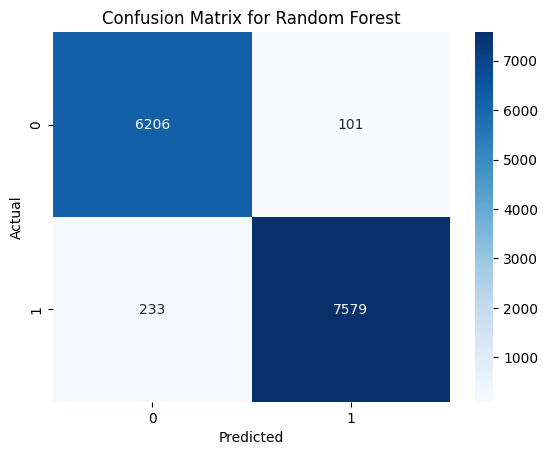

Best parameters for L1 regularization: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


/Users/sunishkasharma/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


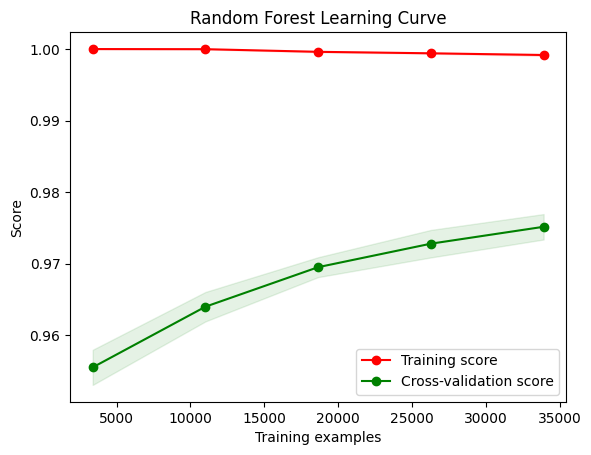

In [8]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Assuming the data loading, preprocessing, feature selection, and model training steps are already correctly implemented in your code.

# Evaluate the Random Forest model with feature selection on training data
y_train_pred_rf = rf_model_selected.predict(X_train_selected)
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
print(f"Training Accuracy with Random Forest: {train_accuracy_rf:.2f}")

# Evaluate the Random Forest model with feature selection on validation data
y_valid_pred_rf = rf_model_selected.predict(X_valid_selected)
valid_accuracy_rf = accuracy_score(y_valid, y_valid_pred_rf)
print(f"Validation Accuracy with Random Forest: {valid_accuracy_rf:.2f}")

# Evaluate the Random Forest model with feature selection on test data
y_test_pred_rf = rf_model_selected.predict(X_test_selected)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print(f"Testing Accuracy with Random Forest: {test_accuracy_rf:.2f}")

# Display classification report and confusion matrix for Random Forest with feature selection
print('\nClassification Report for Random Forest:')
classification_rep_rf = classification_report(y_test, y_test_pred_rf)
print(classification_rep_rf)

print('\nConfusion Matrix for Random Forest:')
confusion_rf = confusion_matrix(y_test, y_test_pred_rf)
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()

# Print the best parameters from the grid search for L1 regularization
print(f"Best parameters for L1 regularization: {grid_search_logistic.best_params_}")

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    rf_model_selected, X_train_selected, y_train, cv=5, n_jobs=2, 
    train_sizes=np.linspace(.1, 1.0, 5))

# Calculate mean and standard deviation for train set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure()
plt.title("Random Forest Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.show()


In [9]:
# ... [previous code] ...

# Make predictions on the validation and test sets
y_valid_pred_rf = rf_model_selected.predict(X_valid_selected)
y_test_pred_rf = rf_model_selected.predict(X_test_selected)

# Evaluate the Random Forest model with feature selection on validation data
valid_accuracy_rf = accuracy_score(y_valid, y_valid_pred_rf)
print(f"Validation Accuracy with Random Forest: {valid_accuracy_rf:.2f}")

# Display classification report for the validation set
print('\nClassification Report for Validation Set with Random Forest:')
classification_rep_valid = classification_report(y_valid, y_valid_pred_rf)
print(classification_rep_valid)

# Evaluate the Random Forest model with feature selection on test data
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print(f"Testing Accuracy with Random Forest: {test_accuracy_rf:.2f}")

# Display classification report for the test set
print('\nClassification Report for Test Set with Random Forest:')
classification_rep_test = classification_report(y_test, y_test_pred_rf)
print(classification_rep_test)

# ... [rest of the code] ...


Validation Accuracy with Random Forest: 0.97

Classification Report for Validation Set with Random Forest:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      6433
           1       0.99      0.96      0.98      7686

    accuracy                           0.97     14119
   macro avg       0.97      0.97      0.97     14119
weighted avg       0.97      0.97      0.97     14119

Testing Accuracy with Random Forest: 0.98

Classification Report for Test Set with Random Forest:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6307
           1       0.99      0.97      0.98      7812

    accuracy                           0.98     14119
   macro avg       0.98      0.98      0.98     14119
weighted avg       0.98      0.98      0.98     14119



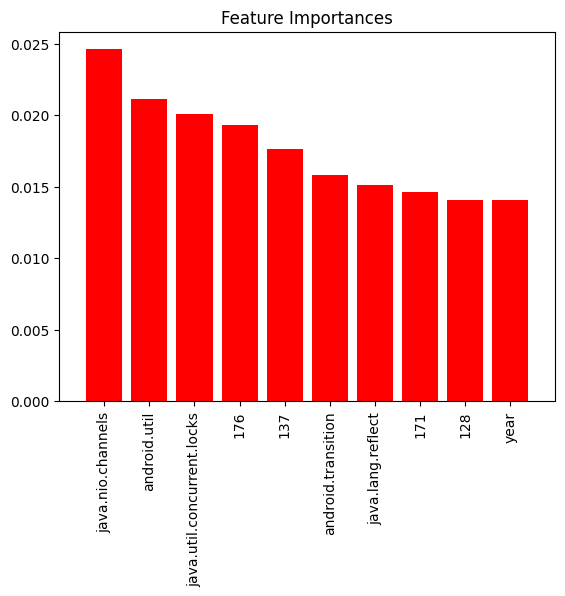

In [10]:
importances = rf_model_selected.feature_importances_
indices = np.argsort(importances)[::-1]

# To make the plot more readable, we can just display a certain number of top features
top_k = 10  # Show top 10 features
selected_features_names = X.columns[important_features][indices[:top_k]]

plt.figure()
plt.title("Feature Importances")
plt.bar(range(top_k), importances[indices[:top_k]], color="r", align="center")
plt.xticks(range(top_k), selected_features_names, rotation=90)
plt.xlim([-1, top_k])
plt.show()


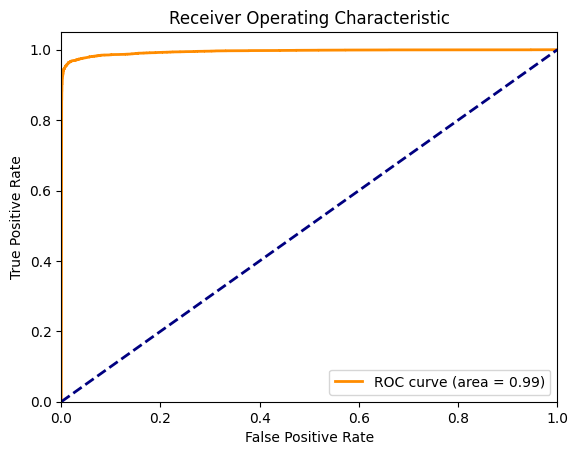

In [11]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve and AUC for validation set
fpr, tpr, thresholds = roc_curve(y_valid, rf_model_selected.predict_proba(X_valid_selected)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


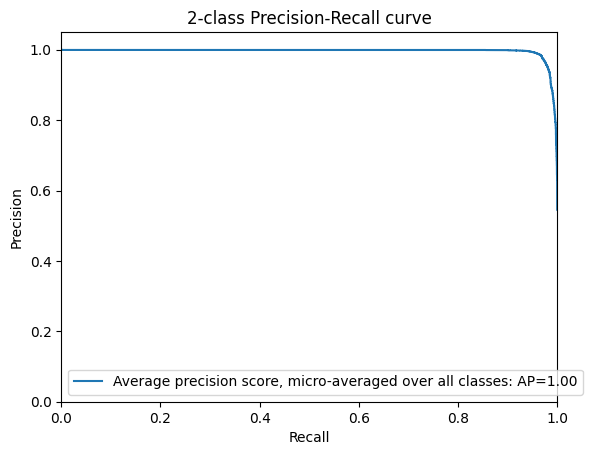

In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_valid, rf_model_selected.predict_proba(X_valid_selected)[:,1])
average_precision = average_precision_score(y_valid, rf_model_selected.predict_proba(X_valid_selected)[:,1])

plt.figure()
plt.step(recall, precision, where='post', label='Average precision score, micro-averaged over all classes: AP={0:0.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')
plt.legend(loc="best")
plt.show()
